In [1]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
from channel_classifier.internal.ee_utils import add_labels, compute_error_image, download_tiff, get_landsat_image, get_landsat_composite
from channel_classifier.internal.settings import TRAINING_BANDS, MODIS_KEEP_VALUES, JRC_VALUES

In [13]:
def add_labels(image, year=None, month=None, bands=TRAINING_BANDS, mask_channel=False, aggregate_unused_labels=False):
    if not year and not month:
        year = image.date().get('year').getInfo()
        month = image.date().get('month').getInfo()

    data_mask = image.neq(ee.Number(0)).select('B1')
    proj = image.projection()
    
    modis_year = min(year, 2016)
    timestamp = '{}_01_01'.format(modis_year)
    modis = ee.Image('MODIS/006/MCD12Q1/{}'.format(timestamp)).select('LC_Type1')#.reproject(proj)
    
    label_values = np.arange(0, 18)
    discard_values = list(set(label_values) - set(MODIS_KEEP_VALUES))
    for value in discard_values:
        mask = modis.neq(ee.Number(value))
        if aggregate_unused_labels:
            modis = modis.multiply(mask).add(ee.Number(3).multiply(mask))
        else:
            modis = modis.multiply(mask)
        
    modis = modis.add(ee.Number(1))
    modis = modis.multiply(modis.neq(ee.Number(1)))

    stacked = modis.clip(image.geometry())
    
    jrc_year = min(year, 2015)
    timestamp = '{:d}_{:02d}'.format(jrc_year, month)
    water = ee.Image('JRC/GSW1_0/MonthlyHistory/{}'.format(timestamp))#.reproject(proj)
    for k in JRC_VALUES:
        mask = water.neq(ee.Number(k))
        stacked = stacked.multiply(mask)
        stacked = stacked.add(water.eq(ee.Number(k)))

    new_bands = stacked.bandNames().getInfo()
    new_bands.remove('LC_Type1')
    new_bands.append('label')
    stacked = stacked.rename(new_bands).clip(image.geometry())

    stacked = stacked.updateMask(data_mask)

    if mask_channel:
        channel_mask = water.eq(ee.Number(2)).clip(image.geometry())
        channel_mask = channel_mask.focal_max(CHANNEL_MASK_RADIUS).focal_min(CHANNEL_MASK_RADIUS)
        stacked = stacked.updateMask(channel_mask)

    return image.select(bands).addBands(stacked)


In [14]:
CLOUD_THRESH = 20.0

In [4]:
ee.Initialize()

In [5]:
MODIS_LABELS = ['']

In [6]:
#path, row = [7, 65] # Ucayali
path, row = [3, 69] # RMDD
year, month, day = [2014, 9, 7]
image = get_landsat_composite(path, row, year)

In [7]:
image = get_landsat_composite(path, row, 2014)

[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'B8', u'B9', u'B10', u'B11', u'BQA']


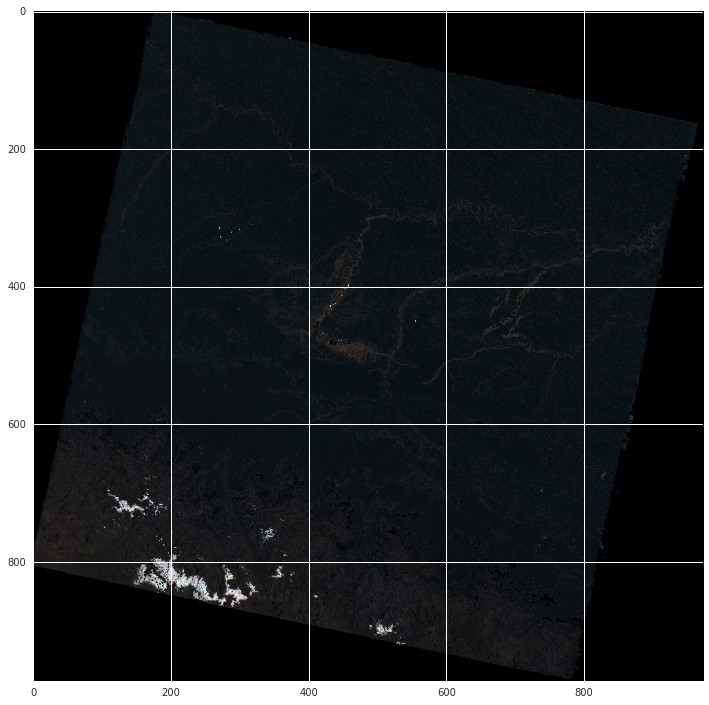

In [8]:
print(image.bandNames().getInfo())
filename = download_tiff(image.clip(image.geometry()), scale=240)
with rasterio.open(filename) as r:
    im = r.read()
rgb = np.stack([im[3], im[2], im[1]], axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(rgb)

In [15]:
month = 8
stacked = add_labels(image, year, month, aggregate_unused_labels=False)
filename = download_tiff(stacked, scale=200)

In [16]:
bands = stacked.bandNames().getInfo()
print(bands)
print(stacked.select(['B2']).projection().getInfo())
print(stacked.select(['label']).projection().getInfo())

[u'B6', u'B5', u'B4', u'B3', u'B2', u'label']
{u'crs': u'EPSG:4326', u'type': u'Projection', u'transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}
{u'crs': u'SR-ORG:6974', u'type': u'Projection', u'transform': [463.312716528, 0.0, -20015109.354, 0.0, -463.312716527, 10007554.677]}


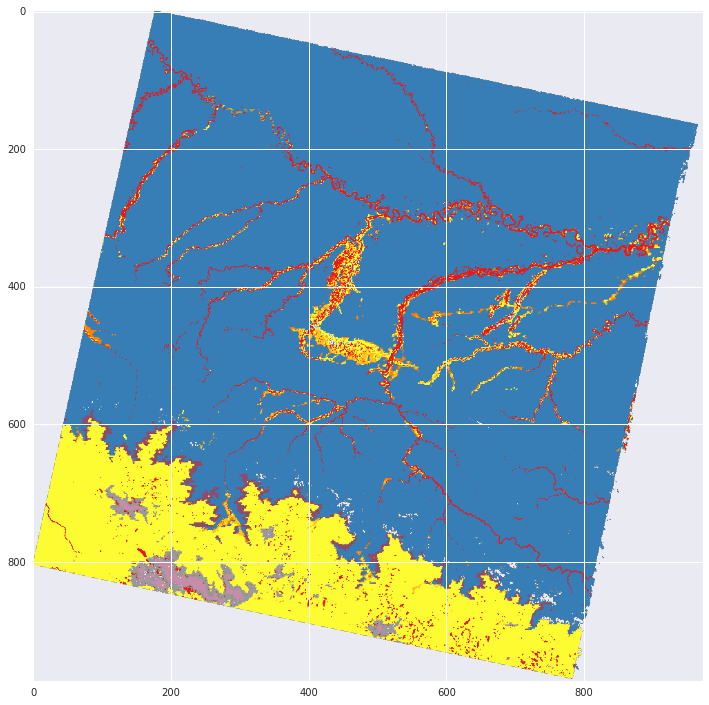

In [17]:
filename = download_tiff(stacked.clip(image.geometry()), scale=240)
with rasterio.open(filename) as r:
    i = r.count
    labels = r.read(i).astype(float)
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1')

In [13]:
proj = stacked.select(['B2']).projection()
print(stacked.select(['label']).projection().getInfo())

{u'crs': u'EPSG:4326', u'type': u'Projection', u'transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}


In [49]:
training = stacked.sample(numPixels=10000, projection=proj, scale=1, seed=0).select(bands).filter(ee.Filter.neq('label', 0))
validation = stacked.sample(numPixels=10000, projection=proj, scale=1, seed=1).select(bands).filter(ee.Filter.neq('label', 0))

In [50]:
classifier = ee.Classifier.randomForest(10).train(training, 'label')

In [51]:
classified = stacked.classify(classifier, 'classification')

In [52]:
validated = validation.classify(classifier, 'classification')
accuracy = validated.errorMatrix('label', 'classification')
print(accuracy.accuracy().getInfo())

0.929547088426


In [53]:
error = compute_error_image(stacked.select(['label']), classified.clip(image.geometry()), 1)

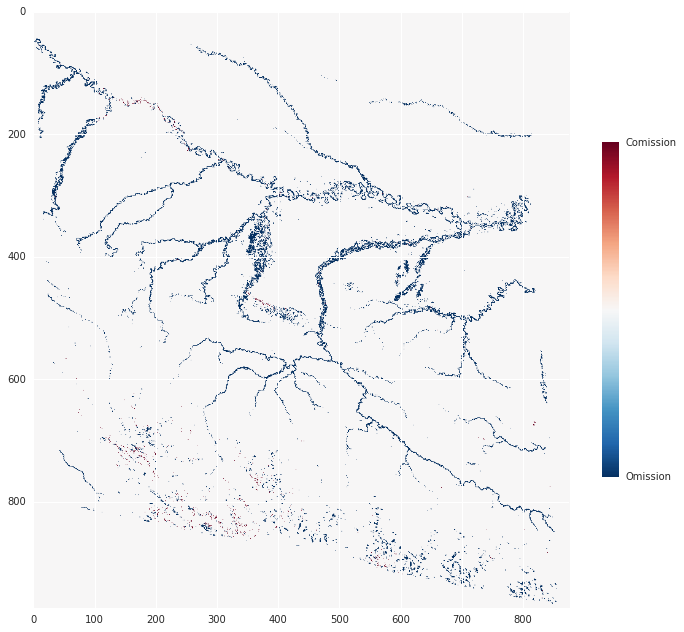

In [54]:
filename = download_tiff(error, scale=240)
with rasterio.open(filename) as r:
    err = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);

In [55]:
filename = download_tiff(classified.select(['classification']), scale=200)

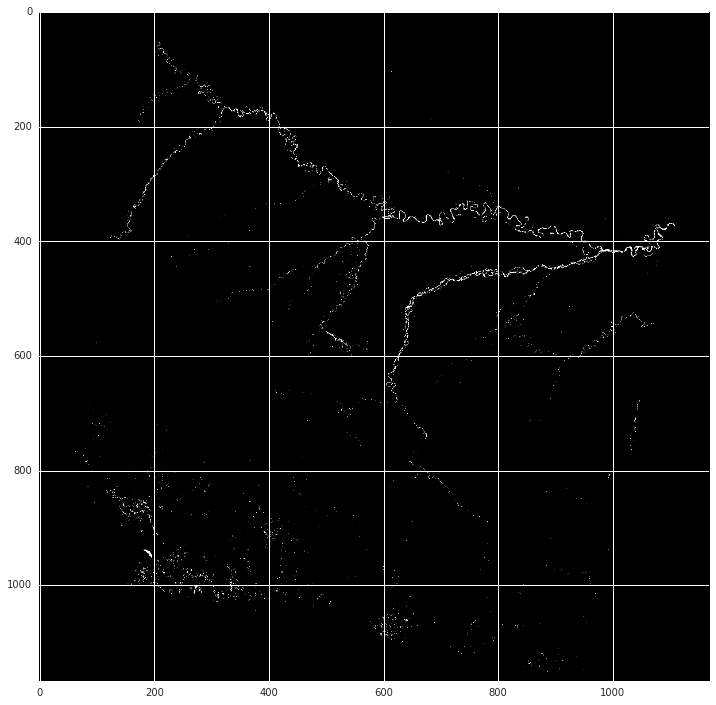

In [56]:
keep_labels = [1, 12]
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
    labels[labels == 0] = np.nan
    good_labels = np.isin(labels, keep_labels).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(good_labels, cmap='binary_r')
#cb = plt.colorbar(im, ax=ax, shrink=0.5)

In [57]:
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing, disk, white_tophat
from skimage.measure import label

(400, 200)

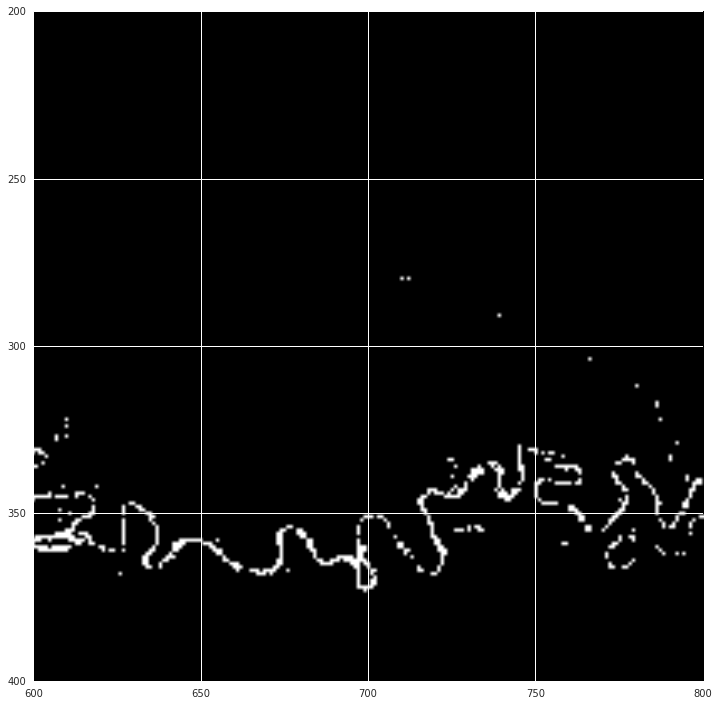

In [61]:
yl = [400, 200]
xl = [600, 800]
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(good_labels, cmap='binary_r')
ax.set_xlim(xl)
ax.set_ylim(yl)

(2032, 1363056)


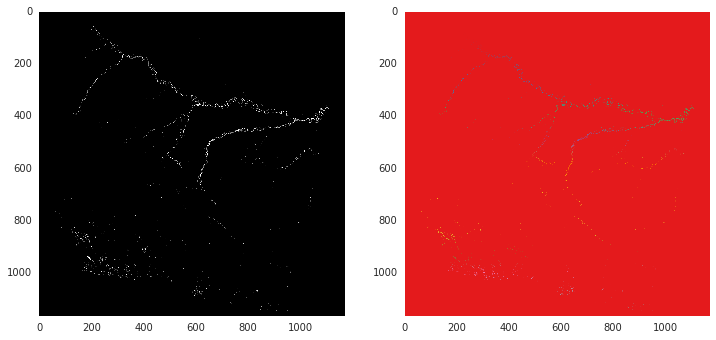

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12,12))
mask = good_labels
#mask = good_labels - white_tophat(good_labels)
components = label(mask, background=0, neighbors=8)#.astype(float)
#components[components == 0] = np.nan
im = ax[0].imshow(mask, cmap='binary_r')
im = ax[1].imshow(components, cmap='Set1')
#plt.colorbar(im, ax=ax[1], shrink=0.5)
print(np.unique(components).shape[0], np.prod(mask.shape))
for axis in ax:
    axis.grid('off')
    #axis.set_xlim(xl)
    #axis.set_ylim(yl)

In [ ]:
#from channel_classifier.internal.ee_utils import save_binary_mask

In [ ]:
#save_binary_mask(classified.select(['classification']), 'test_mask.tif')